# Recommendation Systems

# Outline

1. What are Recommendation Systems?
2. Why do we need Recommendation Systems?
3. Applications of Recommendation Systems in products that we use daily ?
    + Ecommerce sites: Amazon/Flipkart
    + Video Streaming: Netflix/Youtube/Prime Videos
    + music streaming: Saavn/Gaana/Spotify
    + Book recommendations: Goodreads
4. Formal problem statement
5. What are the different techniques of building Recommendation Systems?
    + Content Based
    + Collaborative Filtering
    + Hybrid
6. Dataset - brief description
7. Build recommendation Systems incrementally -
    + Recommend most popular items
    + item-item similarity recommendation
    + user-user similarity recommendation
    + Matrix-Factorization based recommendation
8. Problems with recommendation systems in general.

# Use Cases

<img src='images/netflix1.png'>


<br>


<img src='images/netflix3.png'>

<br>

<img src='images/amazon.png'>

<br>

<img src='images/amazon2.png'>

# https://github.com/saikatkumardey/recommendation-systems

# The Dataset - Review Apps For Android

Download it from http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android_5.json.gz

In [30]:
import pandas as pd
import gzip
from pprint import pprint
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
ls data

meta_Apps_for_Android.json.gz       reviews_Apps_for_Android_5.json
ratings_Apps_for_Android.csv        reviews_Apps_for_Android_5.json.gz
ratings_Movies_and_TV.csv


In [32]:
#as given in the site

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


In [33]:
df = getDF('data/reviews_Apps_for_Android_5.json.gz')

In [34]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1383350400,"11 2, 2013"
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,"12 5, 2011"
2,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1337558400,"05 21, 2012"
3,A2B54P9ZDYH167,B004A9SDD8,"Brooke Greenstreet ""Babylove""","[3, 4]",My 1 year old goes back to this game over and ...,5.0,We love our Monkeys!,1354752000,"12 6, 2012"
4,AFOFZDTX5UC6D,B004A9SDD8,C. Galindo,"[1, 1]",There are three different versions of the song...,5.0,This is my granddaughters favorite app on my K...,1391212800,"02 1, 2014"


<br>
<br>
## metadata:

    reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B

    asin - ID of the product, e.g. 0000013714

    reviewerName - name of the reviewer

    helpful - helpfulness rating of the review, e.g. 2/3

    reviewText - text of the review

    overall - rating of the product

    summary - summary of the review

    unixReviewTime - time of the review (unix time)

    reviewTime - time of the review (raw)
    
<br>
<br>

In [35]:
#rename certain columns
df = df.rename(columns={'asin':'itemID','overall':'rating'})

In [36]:
from random import choice

desktop_agents = ['Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1) AppleWebKit/602.2.14 (KHTML, like Gecko) Version/10.0.1 Safari/602.2.14',
                 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36',
                 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.98 Safari/537.36',
                 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.98 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:50.0) Gecko/20100101 Firefox/50.0']
 
def get_random_header():
    return {'User-Agent': choice(desktop_agents),'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'}

# get name of the items
import requests
from bs4 import BeautifulSoup
from functools import lru_cache

#cache up to 1000 items to avoid calling the API repeatedly
@lru_cache(maxsize=1000)
def get_name_of_item(itemID):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    url = "https://www.amazon.com/dp/"
    item_url = url+itemID
    html = requests.get(item_url,headers=get_random_header())
    soup = BeautifulSoup(html.content,"html5lib")
    item = soup.find(name='div',attrs={'id':'mas-title'})
    item_name = ""
    if item!=None and len(item.contents) >0:
        item_name = item.contents[0].string
    return item_name

In [37]:
get_name_of_item("B00FAPF5U0")

'Candy Crush Saga'

In [38]:
print("number of reviews: ",df.shape[0])
print("number of items: ",df.itemID.unique().shape[0])
print("number of users: ",df.reviewerID.unique().shape[0])

number of reviews:  752937
number of items:  13209
number of users:  87271


# Data Exploration

In [39]:
# most frequent reviewers

In [40]:
reviewer_freq = df.reviewerID.value_counts()

In [41]:
reviewer_freq.head()

A1X1CEGHTHMBL1    565
ACX8G3IW95BNE     513
A2C05OHYJERICI    469
A3F3B6HY9RJI04    467
A1VM5Y6BL07X9X    338
Name: reviewerID, dtype: int64

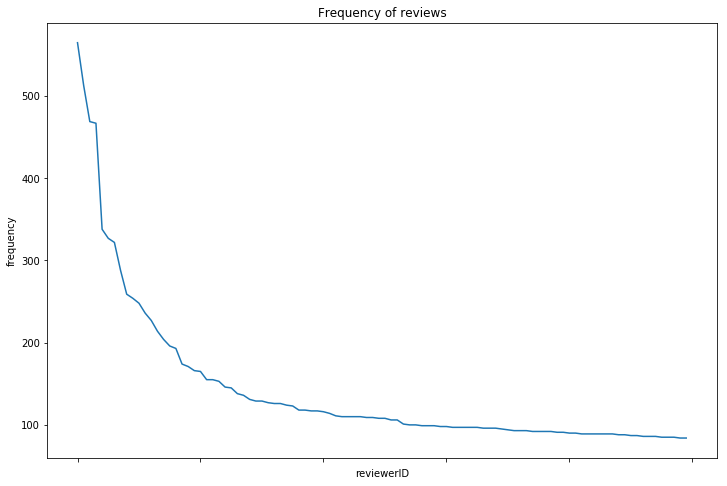

In [48]:
fig,ax = plt.subplots(figsize=(12,8))
reviewer_freq[:100].plot()
plt.title('Frequency of reviews')
plt.xlabel('reviewerID')
plt.ylabel('frequency')
plt.plot();

In [49]:
# most frequently reviewed items

In [50]:
item_freq = df.itemID.value_counts()

In [51]:
item_freq.head()

B00FAPF5U0    6282
B0086700CM    4637
B00992CF6W    4018
B009UX2YAC    3814
B0064X7B4A    3763
Name: itemID, dtype: int64

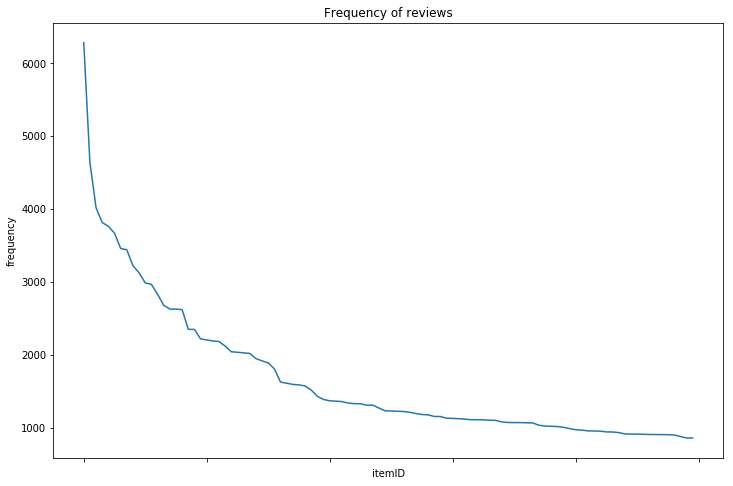

In [52]:
fig,ax = plt.subplots(figsize=(12,8))
item_freq[:100].plot()
plt.title('Frequency of reviews')
plt.xlabel('itemID')
plt.ylabel('frequency')
plt.plot();

In [53]:
# rating distribution

In [54]:
rating_df = df.rating.value_counts()
rating_df.head()

5.0    386637
4.0    158081
3.0     85121
1.0     78713
2.0     44385
Name: rating, dtype: int64

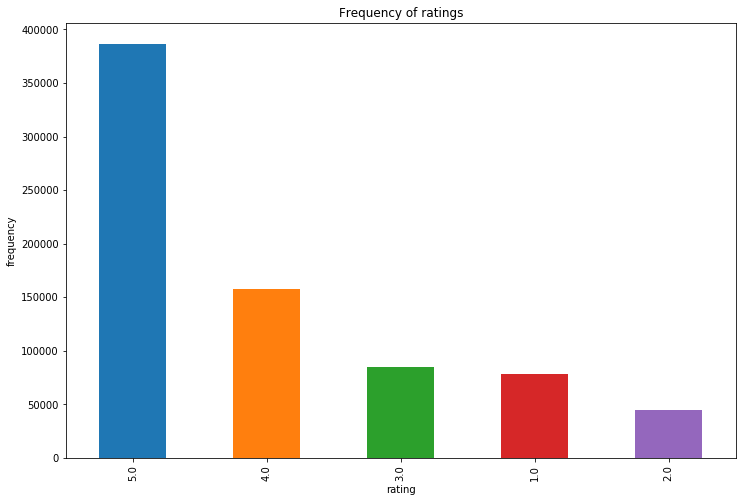

In [55]:
fig,ax = plt.subplots(figsize=(12,8))
rating_df.plot(kind='bar')
plt.title('Frequency of ratings')
plt.xlabel('rating')
plt.ylabel('frequency')
plt.plot();

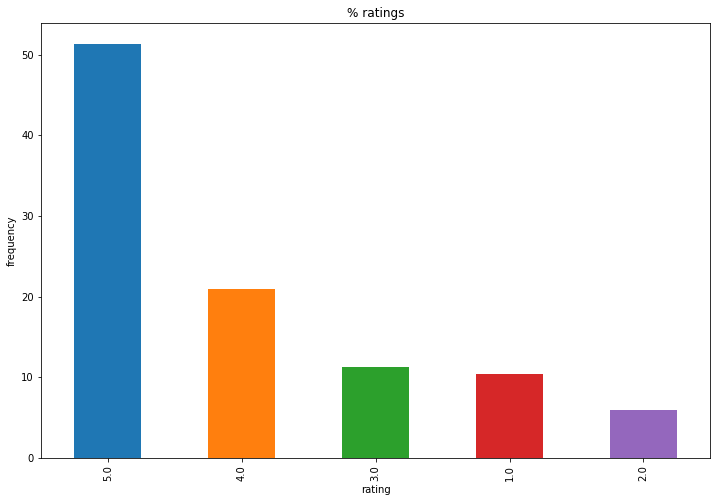

In [57]:
rating_pct_df = df.rating.value_counts()*100.0/df.rating.value_counts().sum()
rating_pct_df.head()

fig,ax = plt.subplots(figsize=(12,8))
rating_pct_df.plot(kind='bar')
plt.title('% ratings')
plt.xlabel('rating')
plt.ylabel('frequency')
plt.plot();

# Data preparation

In [58]:
df.head()

,reviewerID,itemID,reviewerName,helpful,reviewText,rating,summary,unixReviewTime,reviewTime
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1383350400,"11 2, 2013"
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,"12 5, 2011"
2,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1337558400,"05 21, 2012"
3,A2B54P9ZDYH167,B004A9SDD8,"Brooke Greenstreet ""Babylove""","[3, 4]",My 1 year old goes back to this game over and ...,5.0,We love our Monkeys!,1354752000,"12 6, 2012"
4,AFOFZDTX5UC6D,B004A9SDD8,C. Galindo,"[1, 1]",There are three different versions of the song...,5.0,This is my granddaughters favorite app on my K...,1391212800,"02 1, 2014"


In [60]:
columns = ['reviewerID', 'itemID', 'rating']

In [61]:
data = df[columns]
data.head()

,reviewerID,itemID,rating
0,A1N4O8VOJZTDVB,B004A9SDD8,3.0
1,A2HQWU6HUKIEC7,B004A9SDD8,5.0
2,A1SXASF6GYG96I,B004A9SDD8,5.0
3,A2B54P9ZDYH167,B004A9SDD8,5.0
4,AFOFZDTX5UC6D,B004A9SDD8,5.0


In [63]:
k=1000
top_k_users = reviewer_freq.index[:k]
top_k_items  = item_freq.index[:k]

In [67]:
print("top 10 users: ",top_k_users[:10])

top 10 users:  Index(['A1X1CEGHTHMBL1', 'ACX8G3IW95BNE', 'A2C05OHYJERICI', 'A3F3B6HY9RJI04',
       'A1VM5Y6BL07X9X', 'A1E1LEVQ9VQNK', 'ASXYFYCPIP232', 'A2YAUX8C73PN43',
       'AVVK3WYO1TRZO', 'A17KRI7HC6NF69'],
      dtype='object')


In [68]:
print("top 10 items: ",top_k_items[:10])

top 10 items:  Index(['B00FAPF5U0', 'B0086700CM', 'B00992CF6W', 'B009UX2YAC', 'B0064X7B4A',
       'B00DJFIMW6', 'B0054JZC6E', 'B0063IH60K', 'B005ZXWMUS', 'B009HKL4B8'],
      dtype='object')


In [70]:
data_with_top_k_users = data[data.reviewerID.isin(top_k_users)]
data_with_top_k_users.head()

,reviewerID,itemID,rating
31,AK3IFCDU88TI9,B004AFQAUA,4.0
81,A2R2MAYHN4F7GU,B004AHBBPW,5.0
137,ACOM2CL2297RS,B004AHBBPW,5.0
144,A2DWN2MQYWKGNX,B004AHBBPW,3.0
163,A2WT86IPK92CM0,B004AHBBPW,5.0


In [71]:
data_with_top_k_items = data_with_top_k_users[data_with_top_k_users.itemID.isin(top_k_items)]
data_with_top_k_items.head()

,reviewerID,itemID,rating
356,A315MDHWT29JK9,B004ANMWPY,5.0
374,AQRW3O94JUV8F,B004ANMWPY,5.0
402,ACSB6YEM3Q6Q1,B004ANMWPY,5.0
429,A36A1ZYZH8568P,B004ANMWPY,4.0
431,ACX8G3IW95BNE,B004ANMWPY,5.0


In [72]:
data_with_top_k_users.shape

(56865, 3)

In [73]:
data_with_top_k_items.shape

(23948, 3)

In [77]:
# data summary after sampling
print("number of reviewers: ",data_with_top_k_items.reviewerID.unique().shape[0])
print("number of items: ",data_with_top_k_items.itemID.unique().shape[0])

number of reviewers:  997
number of items:  1000


In [78]:
data_long_format = data_with_top_k_items.copy()

In [79]:
data_long_format.head()

,reviewerID,itemID,rating
356,A315MDHWT29JK9,B004ANMWPY,5.0
374,AQRW3O94JUV8F,B004ANMWPY,5.0
402,ACSB6YEM3Q6Q1,B004ANMWPY,5.0
429,A36A1ZYZH8568P,B004ANMWPY,4.0
431,ACX8G3IW95BNE,B004ANMWPY,5.0


# Implementation



## Popularity Based Model

In [80]:
def recommend_most_popular_items(k=10):
    
    most_popular_items = data_long_format.itemID.value_counts()
    most_popular_items_ids = most_popular_items.index
    return most_popular_items_ids[:k]
    

In [81]:
most_popular_items = recommend_most_popular_items()

In [82]:
most_popular_items

Index(['B00FAPF5U0', 'B005ZXWMUS', 'B0063IH60K', 'B004SJ3BCI', 'B0086700CM',
       'B008JGSM6G', 'B0094BB4TW', 'B005HSL626', 'B0064X7FVE', 'B0064X7B4A'],
      dtype='object')

In [83]:
names_of_items = [get_name_of_item(item) for item in most_popular_items]

In [85]:
pprint(names_of_items)

['Candy Crush Saga',
 'Netflix',
 'Solitaire',
 'Angry Birds Free',
 'Temple Run',
 'Flow Free',
 'Facebook',
 'Fruit Ninja Free',
 '',
 '']


## Similarity Based Models

### item-item Similarity

In [86]:
data_long_format.head()

,reviewerID,itemID,rating
356,A315MDHWT29JK9,B004ANMWPY,5.0
374,AQRW3O94JUV8F,B004ANMWPY,5.0
402,ACSB6YEM3Q6Q1,B004ANMWPY,5.0
429,A36A1ZYZH8568P,B004ANMWPY,4.0
431,ACX8G3IW95BNE,B004ANMWPY,5.0


In [87]:
data_long_format['like'] = data_long_format['rating'] >=3

In [88]:
data_long_format.head()

,reviewerID,itemID,rating,like
356,A315MDHWT29JK9,B004ANMWPY,5.0,True
374,AQRW3O94JUV8F,B004ANMWPY,5.0,True
402,ACSB6YEM3Q6Q1,B004ANMWPY,5.0,True
429,A36A1ZYZH8568P,B004ANMWPY,4.0,True
431,ACX8G3IW95BNE,B004ANMWPY,5.0,True


In [89]:
data_long_format.like.value_counts()

True     19975
False     3973
Name: like, dtype: int64

In [94]:
def jaccard_similarity(group_1, group_2):
    """
    group_1, group_2 : list of items
    """
    
    group_1_set = set(group_1)
    group_2_set = set(group_2)
    
    intersection = group_1_set.intersection(group_2_set)
    union = group_1_set.union(group_2_set)
    
    return len(intersection)/len(union)
    

In [95]:
jaccard_similarity([1,2,3],[1,2,3])

1.0

In [96]:
jaccard_similarity([1,2,3],[4,5,6])

0.0

In [97]:
jaccard_similarity([1,2,3],[1,3,4])

0.5

In [93]:
item_user_mapping = data_long_format.groupby('itemID')['reviewerID'].unique()
item_user_mapping.head()

itemID
B004ANMWPY    [A315MDHWT29JK9, AQRW3O94JUV8F, ACSB6YEM3Q6Q1,...
B004DLNC4I    [AK60UXMNOQNFJ, A315MDHWT29JK9, ADLVFFE4VBT8, ...
B004DLPXAO    [A8MTDB180W1XE, A2DGSDMNV02KBP, A2F9G63C1PJZOM...
B004DM1OAQ    [A196EE7NHEO4HM, AX3GWKHTWUZI6, A20PAJNZK0J2UA...
B004DPC5Y2    [A1K1Z8XHZLATOJ, A1Q19JB1PE2V5V, A1DG75OT3Y49E...
Name: reviewerID, dtype: object

In [101]:
item_user_mapping['B004ANMWPY']

array(['A315MDHWT29JK9', 'AQRW3O94JUV8F', 'ACSB6YEM3Q6Q1',
       'A36A1ZYZH8568P', 'ACX8G3IW95BNE', 'AQ5A10N61H758',
       'A2GAUG7MPGJQ1B', 'A58437AUQICZF', 'A10ANCEOWK5GBN',
       'A1P8OFY33JAV6I', 'A1NH2CPKTA3P5J'], dtype=object)

In [99]:
item_item_similarity = {}

In [107]:
num_items = item_user_mapping.shape[0]
# num_items = 5
all_items = item_user_mapping.index

for first_item_index in range(num_items):

    #get all similar item mapping with the first item
    first_item_id = all_items[first_item_index]
    first_item_group = item_user_mapping[first_item_id]
    first_item_sim_group = item_item_similarity.get(first_item_id,{})
    
    for second_item_index in range(num_items):
             
        second_item_id = all_items[second_item_index]
        second_item_group = item_user_mapping[second_item_id]
    
        sim_score = jaccard_similarity(first_item_group, second_item_group)
        
        #store the first-item & second item sim score in the dict
        first_item_sim_group[second_item_id] = sim_score
        
        #update the dict
        item_item_similarity[first_item_id] = first_item_sim_group
    
                

In [108]:
pd.DataFrame(item_item_similarity).head()

,B004ANMWPY,B004DLNC4I,B004DLPXAO,B004DM1OAQ,B004DPC5Y2,B004DPCSKI,B004DPIEF6,B004EBZX6W,B004EFYZ1C,B004FOA84A,...,B00IZLM8MY,B00J206J5E,B00JOT3HQ2,B00JTKDTLE,B00JV858HM,B00JVZ0DQG,B00K7C17QW,B00K7WGUKA,B00KOEHQCW,B00KWVZ750
B004ANMWPY,1.000000,0.022222,0.076923,0.000000,0.000000,0.000000,0.000000,0.069767,0.048780,0.020833,...,0.0,0.000000,0.000000,0.000000,0.023810,0.000000,0.000000,0.0,0.000000,0.000000
B004DLNC4I,0.022222,1.000000,0.031250,0.037037,0.023256,0.033898,0.026316,0.111111,0.030769,0.013889,...,0.0,0.017241,0.026316,0.020833,0.000000,0.000000,0.023256,0.0,0.017544,0.021277
B004DLPXAO,0.076923,0.031250,1.000000,0.000000,0.052632,0.017857,0.027778,0.157895,0.125000,0.045455,...,0.0,0.000000,0.000000,0.000000,0.032787,0.000000,0.000000,0.0,0.000000,0.000000
B004DM1OAQ,0.000000,0.037037,0.000000,1.000000,0.000000,0.000000,0.000000,0.018182,0.019231,0.000000,...,0.0,0.000000,0.000000,0.029412,0.039216,0.060606,0.000000,0.0,0.000000,0.000000
B004DPC5Y2,0.000000,0.023256,0.052632,0.000000,1.000000,0.000000,0.019608,0.023256,0.025000,0.021739,...,0.0,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [109]:
item_item_sim_df = pd.DataFrame(item_item_similarity)

In [110]:
def recommend_similar_items(item_itemID, k=10):
    
    #look up in item_item_sim dataframe
    
    # sort them by sim score
    
    # return top K
    
    pass

### user-user Similarity

In [ ]:
# exercise

### Matrix Factorization Based Approach

<img src='images/mf.jpeg'>

<br>

In [25]:
# data preparation

In [111]:
data_long_format.head()

,reviewerID,itemID,rating,like
356,A315MDHWT29JK9,B004ANMWPY,5.0,True
374,AQRW3O94JUV8F,B004ANMWPY,5.0,True
402,ACSB6YEM3Q6Q1,B004ANMWPY,5.0,True
429,A36A1ZYZH8568P,B004ANMWPY,4.0,True
431,ACX8G3IW95BNE,B004ANMWPY,5.0,True


In [113]:
data_wide_format = data_long_format.pivot(index='reviewerID',columns='itemID',values='rating').fillna(0)
data_wide_format.head()

itemID,B004ANMWPY,B004DLNC4I,B004DLPXAO,B004DM1OAQ,B004DPC5Y2,B004DPCSKI,B004DPIEF6,B004EBZX6W,B004EFYZ1C,B004FOA84A,...,B00IZLM8MY,B00J206J5E,B00JOT3HQ2,B00JTKDTLE,B00JV858HM,B00JVZ0DQG,B00K7C17QW,B00K7WGUKA,B00KOEHQCW,B00KWVZ750
reviewerID,,,,,,,,,,,,,,,,,,,,,
A09529383LS1F1DOJV46O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
A100VWQDTPCP7K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ABATOE1LMSQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ANCEOWK5GBN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10E0SPFC7DXIU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
data_wide_format.shape

(997, 1000)

In [116]:
R = data_wide_format.as_matrix()

/Users/saikat.dey/miniconda3/envs/rs/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [118]:
rating_mean = np.mean(R,axis=1)

In [123]:
rating_mean[:10]

array([0.05 , 0.123, 0.129, 0.075, 0.158, 0.092, 0.143, 0.156, 0.074,
       0.089])

In [120]:
rating_mean.shape

(997,)

In [124]:
R_demeaned = R - rating_mean.reshape(-1,1)

In [125]:
R_demeaned

array([[-0.05 , -0.05 , -0.05 , ..., -0.05 , -0.05 , -0.05 ],
       [-0.123, -0.123, -0.123, ..., -0.123, -0.123, -0.123],
       [-0.129, -0.129, -0.129, ..., -0.129, -0.129, -0.129],
       ...,
       [-0.043, -0.043,  4.957, ..., -0.043, -0.043, -0.043],
       [-0.039, -0.039, -0.039, ..., -0.039, -0.039, -0.039],
       [-0.07 , -0.07 , -0.07 , ..., -0.07 , -0.07 , -0.07 ]])

In [131]:
R_demeaned.shape

(997, 1000)

In [26]:
# matrix factorization svds

In [126]:
from scipy.sparse.linalg import svds
u, sigma, vt = svds(R_demeaned,k=10)

In [128]:
u.shape

(997, 10)

In [132]:
sigma = np.diag(sigma)
sigma.shape

(10, 10)

In [130]:
vt.shape

(10, 1000)

In [27]:
# predictions

In [145]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 5., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [151]:
prediction_df = pd.DataFrame(np.dot(np.dot(u,sigma),vt) + rating_mean.reshape(-1,1))

In [158]:
prediction_df.columns = data_wide_format.columns
prediction_df.index = data_wide_format.index

In [159]:
prediction_df.head()

itemID,B004ANMWPY,B004DLNC4I,B004DLPXAO,B004DM1OAQ,B004DPC5Y2,B004DPCSKI,B004DPIEF6,B004EBZX6W,B004EFYZ1C,B004FOA84A,...,B00IZLM8MY,B00J206J5E,B00JOT3HQ2,B00JTKDTLE,B00JV858HM,B00JVZ0DQG,B00K7C17QW,B00K7WGUKA,B00KOEHQCW,B00KWVZ750
reviewerID,,,,,,,,,,,,,,,,,,,,,
A09529383LS1F1DOJV46O,-0.116727,0.044572,0.090084,0.248981,-0.034159,-0.015769,-0.172684,-0.018902,-0.217911,-0.031985,...,-0.022760,-0.096236,-0.012125,0.099551,0.405321,0.051043,0.010880,0.009449,0.088085,0.041035
A100VWQDTPCP7K,0.056415,-0.076363,-0.074555,-0.030397,0.122250,0.278211,0.077155,-0.118302,-0.122582,0.009736,...,0.264597,0.083380,0.170441,0.176225,0.060414,0.178900,0.131268,0.180355,0.174217,0.200311
A10ABATOE1LMSQ,0.013356,0.265709,-0.018853,0.208069,0.025807,0.124766,0.164930,0.011027,0.134191,0.136469,...,0.192865,-0.002625,-0.013116,0.148849,0.196897,0.315791,0.120808,0.071018,0.505437,0.194805
A10ANCEOWK5GBN,0.120461,0.086528,0.125596,0.160775,0.011817,-0.021264,0.032518,0.231187,0.044203,0.010446,...,-0.004196,-0.023045,0.032737,0.038339,0.158245,0.025058,0.035662,0.018878,0.067494,0.026724
A10E0SPFC7DXIU,-0.113937,0.136343,-0.242196,0.160299,-0.094325,0.534982,0.204337,-0.090864,0.010328,0.191260,...,0.475761,0.041884,0.074607,0.169487,0.176157,0.381778,0.146182,0.055404,0.468775,0.171603


In [161]:
sorted(prediction_df.iloc[0],reverse=True)[:10]

[2.2318318866187603,
 1.422355851771308,
 1.2850573852879026,
 1.2517766911099582,
 1.179525680324379,
 1.092597620306358,
 0.9030518142658729,
 0.8806581289059094,
 0.7824086833462489,
 0.7440877435148022]

# What next ?

# Questions ?

# References:

1. [My blog post](https://medium.com/data-science-for-everyone/how-does-recommendation-systems-work-f3e1c96b14e8)
2. https://beckernick.github.io/matrix-factorization-recommender/
3. https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
4. [Machine Learning Paradigms - Applications in Recommender Systems ](https://www.springer.com/in/book/9783319191348)
5. https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c